<a href="https://colab.research.google.com/github/Jasmeet100/Fake-news-detector/blob/main/fake_n.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Importing Libraries

In [5]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
import re
from wordcloud import WordCloud

In [6]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Embedding, LSTM, Conv1D, MaxPool1D
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report, accuracy_score

# Fake news

In [7]:
fake = pd.read_csv("https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/refs/heads/main/data/Fake.csv")

In [8]:
text = " ".join(fake["text"].tolist())

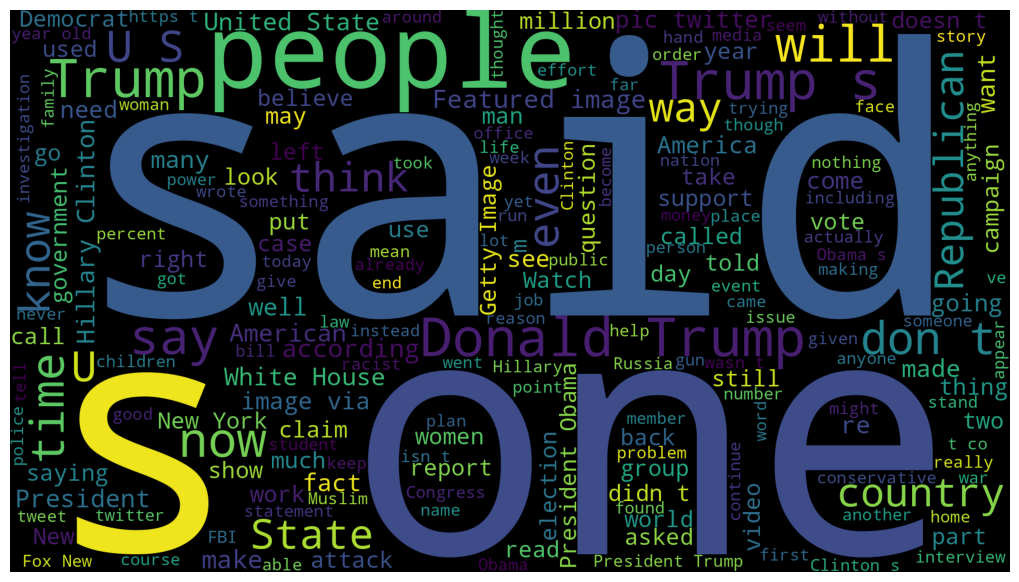

In [9]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

# Real news

In [10]:
real = pd.read_csv('https://raw.githubusercontent.com/laxmimerit/fake-real-news-dataset/refs/heads/main/data/True.csv')

In [11]:
text = " ".join(real["text"].tolist())

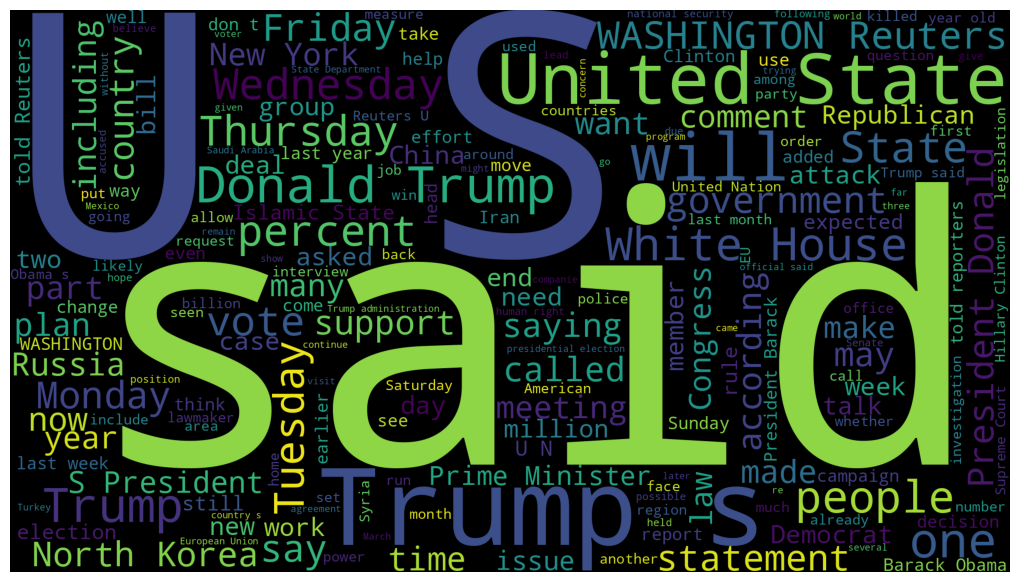

In [12]:
wordcloud = WordCloud(width=1920, height=1080).generate(text)
fig = plt.figure(figsize=(10, 10))
plt.imshow(wordcloud)
plt.axis('off')
plt.tight_layout(pad=0)

# Cleaning Data

In [13]:
#real.sample(4)

In [14]:
unknown_publisher = []
for index, row in enumerate(real.text.values):
  try:
    record = row.split('-', maxsplit=1)
    record[1]

    assert(len(record[0])<120)

  except:
    unknown_publisher.append(index)


In [15]:
len(unknown_publisher)

222

In [16]:
real.iloc[unknown_publisher].text

,text
7,The following statements were posted to the ve...
8,The following statements were posted to the ve...
12,The following statements were posted to the ve...
13,The following statements were posted to the ve...
14,"(In Dec. 25 story, in second paragraph, corre..."
...,...
20135,(Story corrects to million from billion in pa...
20500,"(This Sept 8 story corrects headline, clarifi..."
20667,"(Story refiles to add dropped word not , in ..."
21246,(Story corrects third paragraph to show Mosul...


In [17]:
real.drop(8970, axis=0)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
...,...,...,...,...
21412,'Fully committed' NATO backs new U.S. approach...,BRUSSELS (Reuters) - NATO allies on Tuesday we...,worldnews,"August 22, 2017"
21413,LexisNexis withdrew two products from Chinese ...,"LONDON (Reuters) - LexisNexis, a provider of l...",worldnews,"August 22, 2017"
21414,Minsk cultural hub becomes haven from authorities,MINSK (Reuters) - In the shadow of disused Sov...,worldnews,"August 22, 2017"
21415,Vatican upbeat on possibility of Pope Francis ...,MOSCOW (Reuters) - Vatican Secretary of State ...,worldnews,"August 22, 2017"


In [18]:
publisher = []
tmp_txt = []

for index, row in enumerate(real.text.values):
  if index in unknown_publisher:
    tmp_txt.append(row)
    publisher.append('Unknown')

  else:
    record =  row.split('-', maxsplit = 1)
    publisher.append(record[0].strip())
    tmp_txt.append(record[1].strip())

In [19]:
real['publisher']=publisher
real['text']=tmp_txt

In [20]:
real.head()

,title,text,subject,date,publisher
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017",WASHINGTON (Reuters)
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017",WASHINGTON (Reuters)
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017",WASHINGTON (Reuters)
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017",SEATTLE/WASHINGTON (Reuters)


In [21]:
empty_fake_index = [index for index,text in enumerate(fake.text.tolist()) if str(text).strip()=='']

In [22]:
fake.iloc[empty_fake_index]

,title,text,subject,date
10923,TAKE OUR POLL: Who Do You Think President Trum...,,politics,"May 10, 2017"
11041,Joe Scarborough BERATES Mika Brzezinski Over “...,,politics,"Apr 26, 2017"
11190,WATCH TUCKER CARLSON Scorch Sanctuary City May...,,politics,"Apr 6, 2017"
11225,MAYOR OF SANCTUARY CITY: Trump Trying To Make ...,,politics,"Apr 2, 2017"
11236,SHOCKER: Public School Turns Computer Lab Into...,,politics,"Apr 1, 2017"
...,...,...,...,...
21816,BALTIMORE BURNS: MARYLAND GOVERNOR BRINGS IN N...,,left-news,"Apr 27, 2015"
21826,FULL VIDEO: THE BLOCKBUSTER INVESTIGATION INTO...,,left-news,"Apr 25, 2015"
21827,(VIDEO) HILLARY CLINTON: RELIGIOUS BELIEFS MUS...,,left-news,"Apr 25, 2015"
21857,(VIDEO)ICE PROTECTING OBAMA: WON’T RELEASE NAM...,,left-news,"Apr 14, 2015"


In [23]:
real['text'] = real['text'] + "" + real['title']
fake['text'] = fake['text'] + "" + fake['title']

In [24]:
real["text"] = real['text'].apply(lambda x: str(x).lower())
fake["text"] = fake['text'].apply(lambda x: str(x).lower())

# Preprocessing

In [25]:
real['class']=1
fake['class']=0

In [26]:
real = real[['text','class']]
fake = fake[['text','class']]

In [27]:
data = pd.concat([real, fake], ignore_index=True)

# Vectorsiation

In [1]:
!pip install numpy==1.26.4 # Install compatible numpy version
!pip install gensim==4.3.3 # Install a compatible gensim version
!pip install spacy==3.7.6
!python -m spacy download en_core_web_sm

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 12.8/12.8 MB 115.1 MB/s eta 0:00:00
✔ Download and installation successful
You can now load the package via spacy.load('en_core_web_sm')
⚠ Restart to reload dependencies
If you are in a Jupyter or Colab notebook, you may need to restart Python in
order to load all the package's dependencies. You can do this by selecting the
'Restart kernel' or 'Restart runtime' option.


In [2]:
import gensim #word to vector conversion

In [28]:
y = data['class'].values

In [29]:
X = [d.split() for d in data['text'].tolist()]  #list of lists

In [30]:
DIM = 100
w2v_model = gensim.models.Word2Vec(sentences=X, vector_size=DIM, window=10, min_count=1)

In [ ]:
#w2v_model.wv.most_similar('trump')

In [31]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(X)

In [32]:
X = tokenizer.texts_to_sequences(X)

In [33]:
maxlen = 1000
X = pad_sequences(X, maxlen = maxlen)

In [ ]:
#len(X[100])

In [34]:
vocab_size = len(tokenizer.word_index) + 1
vocab = tokenizer.word_index

In [35]:
def get_weight_matrix(model):
  weight_matrix = np.zeros((vocab_size, DIM))

  for word, i in vocab.items ():
    weight_matrix[i] = model.wv[word]

  return weight_matrix

In [36]:
embedding_vectors = get_weight_matrix(w2v_model) #??

In [37]:
model = Sequential()
model.add(Embedding(vocab_size, output_dim=DIM, weights = [embedding_vectors], input_length = maxlen, trainable=False))
model.add(LSTM(units=128))
model.add(Dense(1, activation='sigmoid'))
model.compile(optimizer='adam', loss='binary_crossentropy', metrics=['acc'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [39]:
X_train, X_test, y_train, y_test = train_test_split(X,y)

In [40]:
model.fit(X_train, y_train, validation_data=(X_test, y_test), epochs=6, batch_size=64)

Epoch 1/6
527/527 ━━━━━━━━━━━━━━━━━━━━ 1044s 2s/step - acc: 0.9342 - loss: 0.1585 - val_acc: 0.9798 - val_loss: 0.0616
Epoch 2/6
527/527 ━━━━━━━━━━━━━━━━━━━━ 1038s 2s/step - acc: 0.9901 - loss: 0.0302 - val_acc: 0.9922 - val_loss: 0.0268
Epoch 3/6
527/527 ━━━━━━━━━━━━━━━━━━━━ 1032s 2s/step - acc: 0.9969 - loss: 0.0101 - val_acc: 0.9932 - val_loss: 0.0229
Epoch 4/6
527/527 ━━━━━━━━━━━━━━━━━━━━ 1056s 2s/step - acc: 0.9977 - loss: 0.0087 - val_acc: 0.9931 - val_loss: 0.0228
Epoch 5/6
527/527 ━━━━━━━━━━━━━━━━━━━━ 1032s 2s/step - acc: 0.9994 - loss: 0.0027 - val_acc: 0.9925 - val_loss: 0.0285
Epoch 6/6
527/527 ━━━━━━━━━━━━━━━━━━━━ 1044s 2s/step - acc: 0.9991 - loss: 0.0032 - val_acc: 0.9892 - val_loss: 0.0323


In [ ]:
y_pred = (model.predict(X_test)>=0.5).astype(int)

337/351 ━━━━━━━━━━━━━━━━━━━━ 6s 451ms/step

In [ ]:
accuracy_score(y_test,y_pred)   #y_pred?

In [ ]:
print(classification_report(y_test, y_pred))

In [ ]:
n = ["this is a news"]
n = tokenizer.texts_to_sequences(n)
n = pad_sequences(n, maxlen=maxlen)

In [ ]:
#model.predict(n)
(model.predict(n)>=0.5).astype(int)